# Natural Lanugage Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from polyglot.detect import Detector
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.filterwarnings('ignore')
from utils import *
data_path = "../data/"

## 1. Sentiment Analysis

### 1-0. Join Dataframes

In [2]:
# join the df with the price & superhost
list_df = pd.read_csv(data_path + "listings_detail.csv")
list_df = list_df[['id', 'price', 'host_is_superhost']]
review_df = pd.read_csv(data_path + "reviews_detail.csv")
review_df = review_df[['listing_id', 'comments']]
review_df.rename(columns={'listing_id':'id'}, inplace=True)
join_df = list_df.merge(review_df) # join listings and the review comments
print("Total Sample:", len(join_df))
print(join_df.head())

Total Sample: 848725
     id  price host_is_superhost  \
0  2595  150.0                 f   
1  2595  150.0                 f   
2  2595  150.0                 f   
3  2595  150.0                 f   
4  2595  150.0                 f   

                                            comments  
0  Notre séjour de trois nuits.\nNous avons appré...  
1                                  Great experience.  
2  I've stayed with my friend at the Midtown Cast...  
3  We've been staying here for about 9 nights, en...  
4  We had a wonderful stay at Jennifer's charming...  


### 1-1. English Reviews

In [3]:
comments = join_df["comments"]
eng_comments = [] # store the english reviews only
for c in comments:
    if type(c) is float: continue
    try:
        c.encode('utf-8')
        lang = Detector(c, quiet=True)
        if (lang.language.name == "English") and (isinstance(c, str)): # also remove invalid data (non-string)
            eng_comments.append(c.encode('utf8'))
    except: continue 

print ("Total English Reviews:", len(eng_comments))

Total English Reviews: 769558


### 1-2. Sentiment Calculation

In [4]:
join_df = join_df[join_df['comments'] == comments] # filter df into english reviews only
join_df['sentiment'] = join_df['comments'].apply(sentiment_calc)
join_df = join_df[join_df['sentiment'] != None] # drop 'None' lists (failed to get sentiments)
print(join_df.head())

     id  price host_is_superhost  \
0  2595  150.0                 f   
1  2595  150.0                 f   
2  2595  150.0                 f   
3  2595  150.0                 f   
4  2595  150.0                 f   

                                            comments  sentiment  
0  Notre séjour de trois nuits.\nNous avons appré...   0.000000  
1                                  Great experience.   0.800000  
2  I've stayed with my friend at the Midtown Cast...   0.410124  
3  We've been staying here for about 9 nights, en...   0.266875  
4  We had a wonderful stay at Jennifer's charming...   0.518750  


### 1-3. Sentiment Analysis for SuperHost vs Host

Superhost & Host sample size: 366722 480652
Superhost Sentiment Mean: 0.40313854086638545
Host Sentiment Mean: 0.38334710307623326


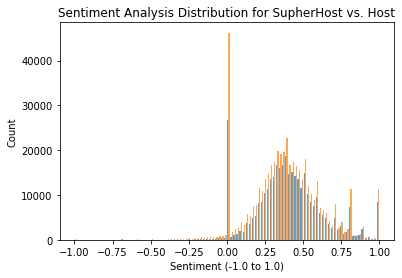

[Text(0.5, 0, 'Sentiment (-1.0 to 1.0)'), Text(0, 0.5, 'Host Count')]

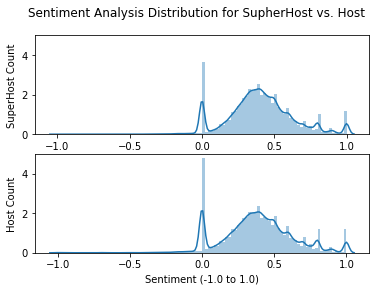

In [5]:
superhost_df = join_df[join_df['host_is_superhost'] == 't'] # get superhost df
host_df = join_df[join_df['host_is_superhost'] == 'f'] # get host df
print("Superhost & Host sample size:", len(superhost_df), len(host_df))
print("Superhost Sentiment Mean:", superhost_df['sentiment'].mean())
print("Host Sentiment Mean:", host_df['sentiment'].mean())

plt.hist([superhost_df['sentiment'], host_df['sentiment']], bins = 100, range=[-1.0, 1.0], alpha=0.7)
plt.title("Sentiment Analysis Distribution for SupherHost vs. Host")
plt.xlabel("Sentiment (-1.0 to 1.0)")
plt.ylabel("Count")
plt.show()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Sentiment Analysis Distribution for SupherHost vs. Host')
p = sns.distplot(superhost_df['sentiment'], kde=True, bins=100, hist=True, ax=ax1)
p.set(ylim=(0, 5)) # set ylim
p.set(xlabel='Sentiment (-1.0 to 1.0)', ylabel='SuperHost Count')
p = sns.distplot(host_df['sentiment'], kde=True, bins=100, hist=True, ax=ax2)
p.set(ylim=(0, 5)) # match the ylim
p.set(xlabel='Sentiment (-1.0 to 1.0)', ylabel='Host Count')

### 1-4. Sentiment Analysis for Price Bin

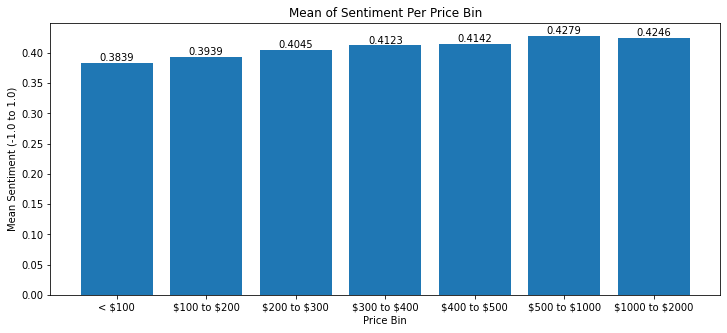

In [6]:
# used same brince bin split
price_100, price_200, price_300, price_400, price_500, price_1000, price_2000 = price_df_split(join_df)

sentiment_mean = [
    price_100['sentiment'].mean(), price_200['sentiment'].mean(), price_300['sentiment'].mean(),
    price_400['sentiment'].mean(), price_500['sentiment'].mean(), 
    price_1000['sentiment'].mean(), price_2000['sentiment'].mean()
]

price_cutoff = [
    "< $100", "\$100 to \$200", "\$200 to \$300", "\$300 to \$400", "\$400 to \$500",
    "\$500 to \$1000", "\$1000 to \$2000"
]

fig = plt.figure(figsize = (12, 5))
plt.bar(price_cutoff, sentiment_mean)
plt.title("Mean of Sentiment Per Price Bin")
plt.xlabel("Price Bin")
plt.ylabel("Mean Sentiment (-1.0 to 1.0)")
for i in range(len(sentiment_mean)):
    plt.annotate(str(round(sentiment_mean[i],4)), xy=(price_cutoff[i],sentiment_mean[i]), ha='center', va='bottom')
plt.show()

## 2. TF-IDF WordCloud

### 2-1. Wordcloud SuperHost vs. Host

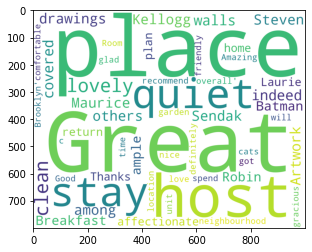

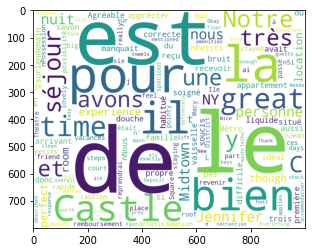

In [7]:
superhost_df = join_df[join_df['host_is_superhost'] == 't'] # get superhost df
host_df = join_df[join_df['host_is_superhost'] == 'f'] # get host df

# superhost
text = superhost_df['comments'].values 

# wordcloud plot
w = WordCloud(width=1000,height=800,mode='RGBA',background_color='white',max_words=2000).generate(str(text))
plt.imshow(w)
plt.show()

# host
text = host_df['comments'].values 

# wordcloud plot
w = WordCloud(width=1000,height=800,mode='RGBA',background_color='white',max_words=2000).generate(str(text))
plt.imshow(w)
plt.show()

### 2-2. Wordcloud Price Bin

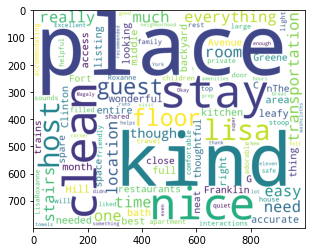

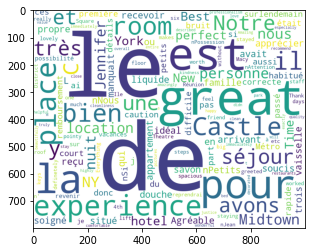

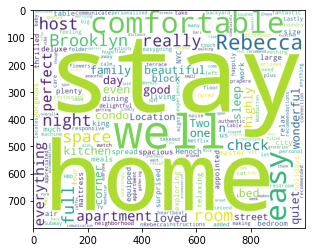

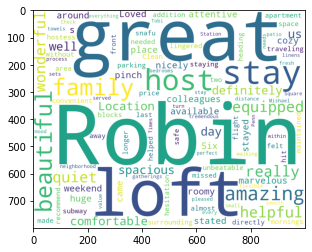

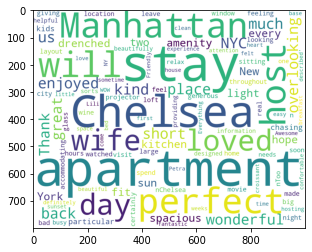

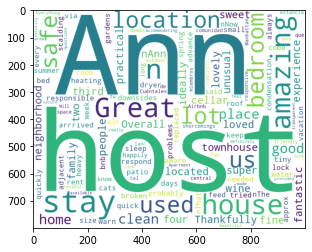

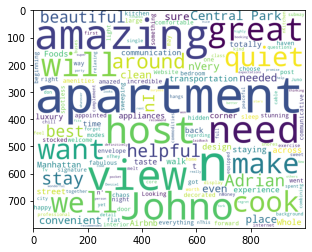

In [8]:
price_100, price_200, price_300, price_400, price_500, price_1000, price_2000 = price_df_split(join_df)
price_dfs = [price_100, price_200, price_300, price_400, price_500, price_1000, price_2000]

for p in price_dfs:
    # each price bin
    text = p['comments'].values 

    # wordcloud plot
    w = WordCloud(width=1000,height=800,mode='RGBA',background_color='white',max_words=2000).generate(str(text))
    plt.imshow(w)
    plt.show()